## Regression Using torchbnn

Github repo: https://github.com/Harry24k/bayesian-neural-network-pytorch

To install:
- `pip install torchbnn`

or:

- `git clone https://github.com/Harry24k/bayesian-neural-network-pytorch`

In [1]:
import os  # Avoids the OpenMP error in conjunction with the below
import numpy as np
from sklearn import datasets

import torch
import torch.nn as nn
import torch.optim as optim

import torchbnn as bnn

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
import pandas as pd
import requests 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device = ",device)
if device.type == "cpu":
    cuda = False
else:
    cuda = True
    
import arviz as az

# Prevent an error about OpenMP popping up when importing os 
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import sys
sys.path.append('../../duq/')
  
# Importing the Bayesian LR module
import pre
import post
import sgld as SG

seed = 1234                  # Assign a value to the seed
pre.set_seed(seed)      # Set the seed for 'random', 'np.random', 'torch.manual_seed' and 'torch.cuda.manual_seed_all'

Device =  cpu
Device =  cpu


In [2]:
def f(x):
    """ Function to plot a damped sinusoid """ 
    A = 2         # Initial amplitude
    lamb = 0.2    # Decay constant
    w = 2         # Angular frequency
    phi = 0       # Phase angle at t=0
    flipped = False # Whether to flip the x axis or not
    if torch.is_tensor(x):
        res = A*torch.exp(-lamb*x)*(torch.cos(w*x+phi) + torch.sin(w*x + phi))
        if flipped:
            res = res.numpy()
            res = np.flip(res).copy()
            res = torch.Tensor(res)
        return res
    else:
        res = A*np.exp(-lamb*x)*(np.cos(w*x+phi) + np.sin(w*x + phi))
        if flipped: res = np.flip(res)
        return res

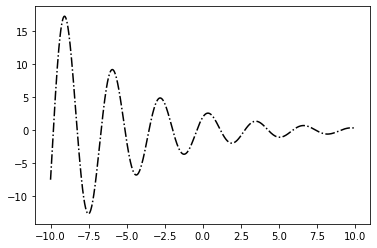

In [3]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(-10,10,1000)
Y = f(X)

plt.plot(X,Y,'k-.')

df = pd.DataFrame({"X":X,"Y":Y})

x_cols=[0]
y_cols=[1]
component = 0 # Sort by the x component 
cutoff_percentile = (0.5,0.5)
val_split = 0.2
component_name = "Y"

df, data_mean, data_std = pre.process_df_euclid(df=df, x_cols=x_cols)

y_mean = data_mean[y_cols].values
x_mean = data_mean[x_cols].values
y_std = data_std[y_cols].values
x_std = data_std[x_cols].values

TRAIN, VAL, TEST = pre.split_data(df, component=component, y_cols=y_cols, x_cols=x_cols, cutoff_percentile=cutoff_percentile, val_split=val_split, seed=seed)
x_train, y_train, train_data, train_indices = TRAIN
x_val, y_val, val_data, val_indices = VAL
x_test, y_test, test_data, test_indices = TEST

In [4]:
num_epochs = 2000
batch_size = len(x_train)
num_units = 300
lr = 5e-4
input_dim = 1
output_dim = 1

In [5]:
model = nn.Sequential(
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=input_dim, out_features=num_units),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=num_units, out_features=num_units),
    nn.ReLU(),
    bnn.BayesLinear(prior_mu=0, prior_sigma=0.1, in_features=num_units, out_features=output_dim)
)

In [6]:
mse_loss = nn.MSELoss()
kl_loss = bnn.BKLLoss(reduction='mean', last_layer_only=False)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [7]:
import time

start = time.time()

for step in range(num_epochs):
    pred = model(x_train)
    mse = mse_loss(pred, y_train)
    kl = kl_loss(model)
    cost = mse + 0.01*kl
    
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    if step%500 == 0:
        print(f"Epoch {step}, kl = {kl.data.numpy()[0]:.5f}, cost = {cost.data.numpy()[0]:.5f}")
        
    
print('- MSE : %2.2f, KL : %2.2f' % (mse.item(), kl.item()))

        
end = time.time()
print(f"Time taken: {end-start}")

Epoch 0, kl = 0.15595, cost = 0.10638
Epoch 500, kl = 0.12650, cost = 0.12654
Epoch 1000, kl = 0.12332, cost = 0.08487
Epoch 1500, kl = 0.12291, cost = 0.14470
- MSE : 0.09, KL : 0.12
Time taken: 19.082699060440063


In [8]:
#x_test, y_test = next(iter(test_loader))
def generate_samples(X, y_mean, y_std, num_tests):
    samples = []
    for i in range(num_tests):
        preds = model.cpu().forward(X).data.numpy()
        
        samples.append(preds)

    samples = np.array(samples)
    samples = pre.unnormalise(samples, y_mean, y_std)

    means = np.zeros((samples.shape[2], samples.shape[1])) # means of shape (num_dependent_vars, num_datapoints)
    stds = np.zeros((samples.shape[2], samples.shape[1])) # means of shape (num_dependent_vars, num_datapoints)

    for i in range(samples.shape[2]):   # Looping over each dependent var
        for j in range(samples.shape[1]): # Looping over each datapoint
            means[i, j] = samples[:, j, i].mean()
            stds[i, j] = samples[:, j, i].std()
    
    samples = np.moveaxis(samples, 2, 0)
    return samples, means, stds

def run_sampling(X, Y, num_tests):
    samples, means, stds= generate_samples(X, y_mean, y_std, num_tests) 

    samples = np.squeeze(samples)

    Y_np = pre.unnormalise(Y.squeeze().numpy(), y_mean, y_std)
    return samples, means, stds, Y_np

num_tests=500

#samples = generate_samples(torch.Tensor(df["X"]).unsqueeze(1), y_mean, y_std, num_tests)
samples_full, means_full, stds_full, y_train_np_full = run_sampling(torch.Tensor(df["X"]).unsqueeze(1), torch.Tensor(df["Y"]).unsqueeze(1), num_tests)
means_full_, stds_full_, x_full_ = post.sort_data([means_full.squeeze(), stds_full.squeeze(), df["X"]], sortby=2)

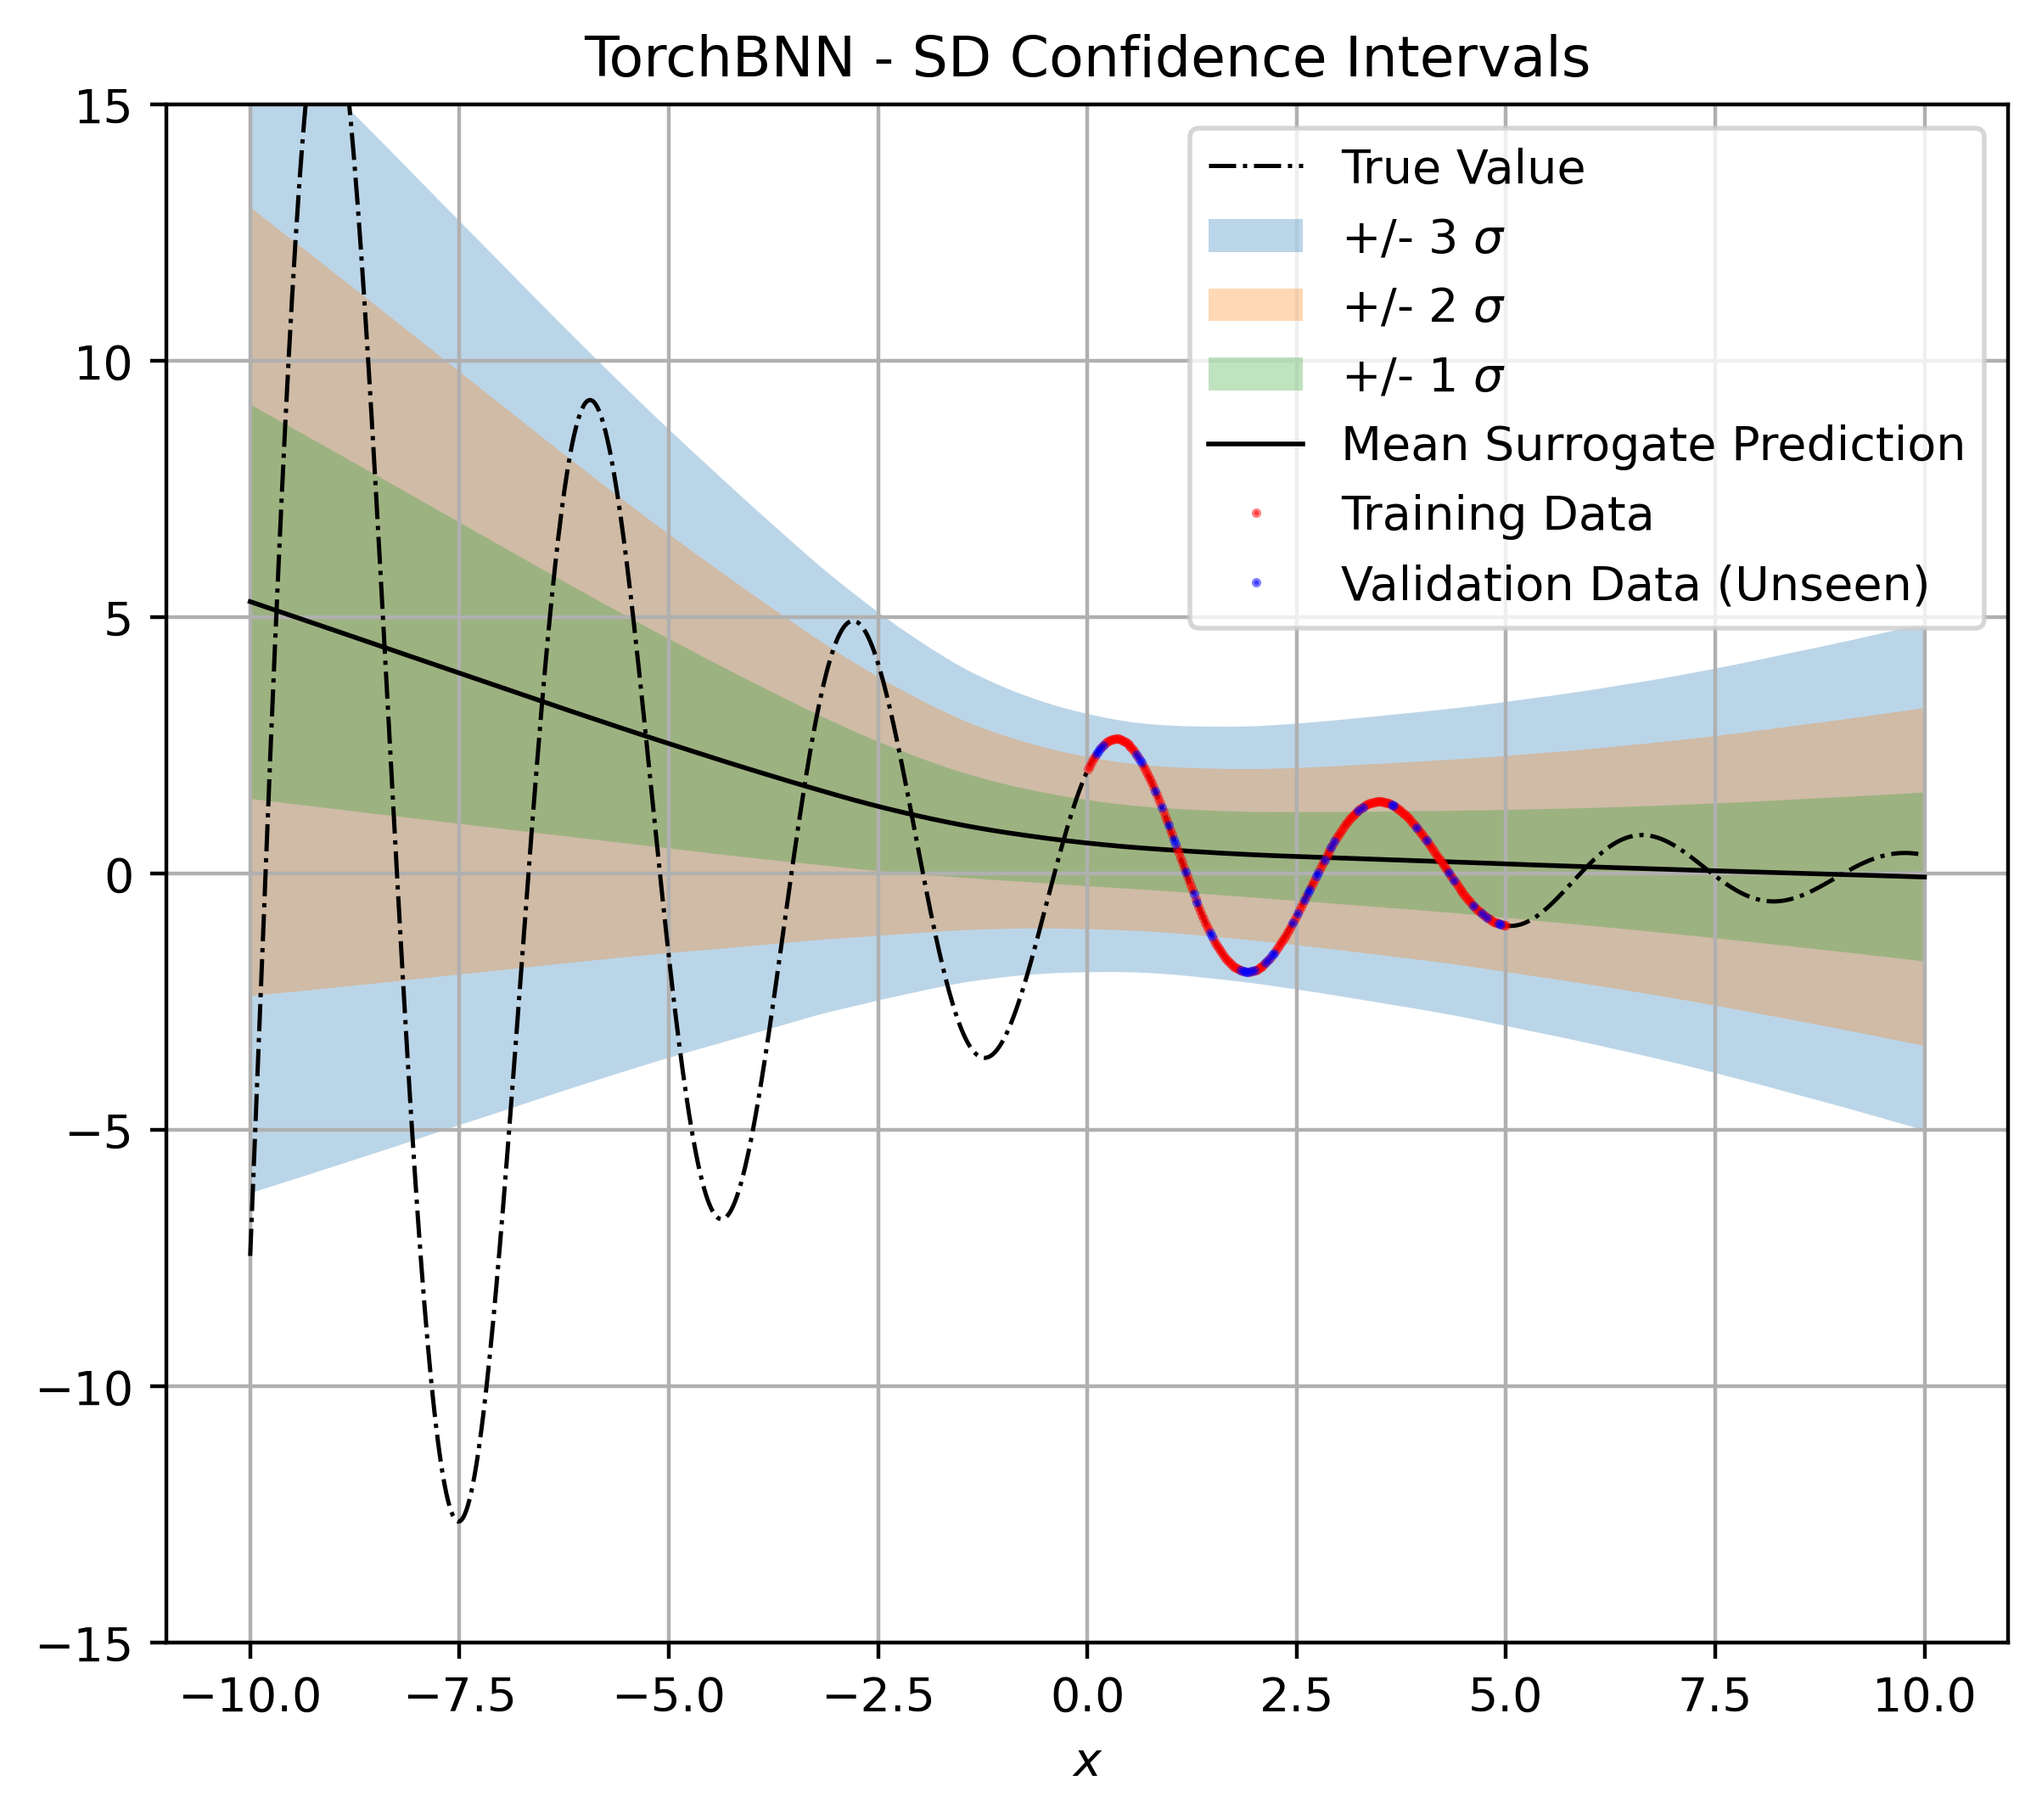

In [18]:

plt.figure(figsize=(7,6), dpi=400)

plt.plot(X, Y, 'k-.',linewidth=0.9,label="True Value")
plt.fill_between(X, means_full_.ravel() + 3*stds_full_.flatten(), means_full_.ravel() - 3*stds_full_.flatten(), alpha = 0.3, label = '+/- 3 $\sigma$')
plt.fill_between(X, means_full_.ravel() + 2*stds_full_.flatten(), means_full_.ravel() - 2*stds_full_.flatten(), alpha = 0.3, label = '+/- 2 $\sigma$')
plt.fill_between(X, means_full_.ravel() + 1*stds_full_.flatten(), means_full_.ravel() - 1*stds_full_.flatten(), alpha = 0.3, label = '+/- 1 $\sigma$')
plt.plot(X, means_full_.squeeze(), color = 'black', linewidth = 1, label="Mean Surrogate Prediction")
plt.plot(X[train_indices], Y[train_indices], 'or', alpha = 0.5, markersize=1, label="Training Data")
plt.plot(X[val_indices], Y[val_indices], 'ob', alpha=0.5, markersize=1, label="Validation Data (Unseen)")
#plt.plot(X[test_indices], Y[test_indices], 'oy', alpha=0.5, markersize=3, label="Test Data (Unseen)")
plt.ylim((-15,15))
plt.grid()
plt.legend()
plt.xlabel('$x$')
plt.title('TorchBNN - SD Confidence Intervals')
plt.show()

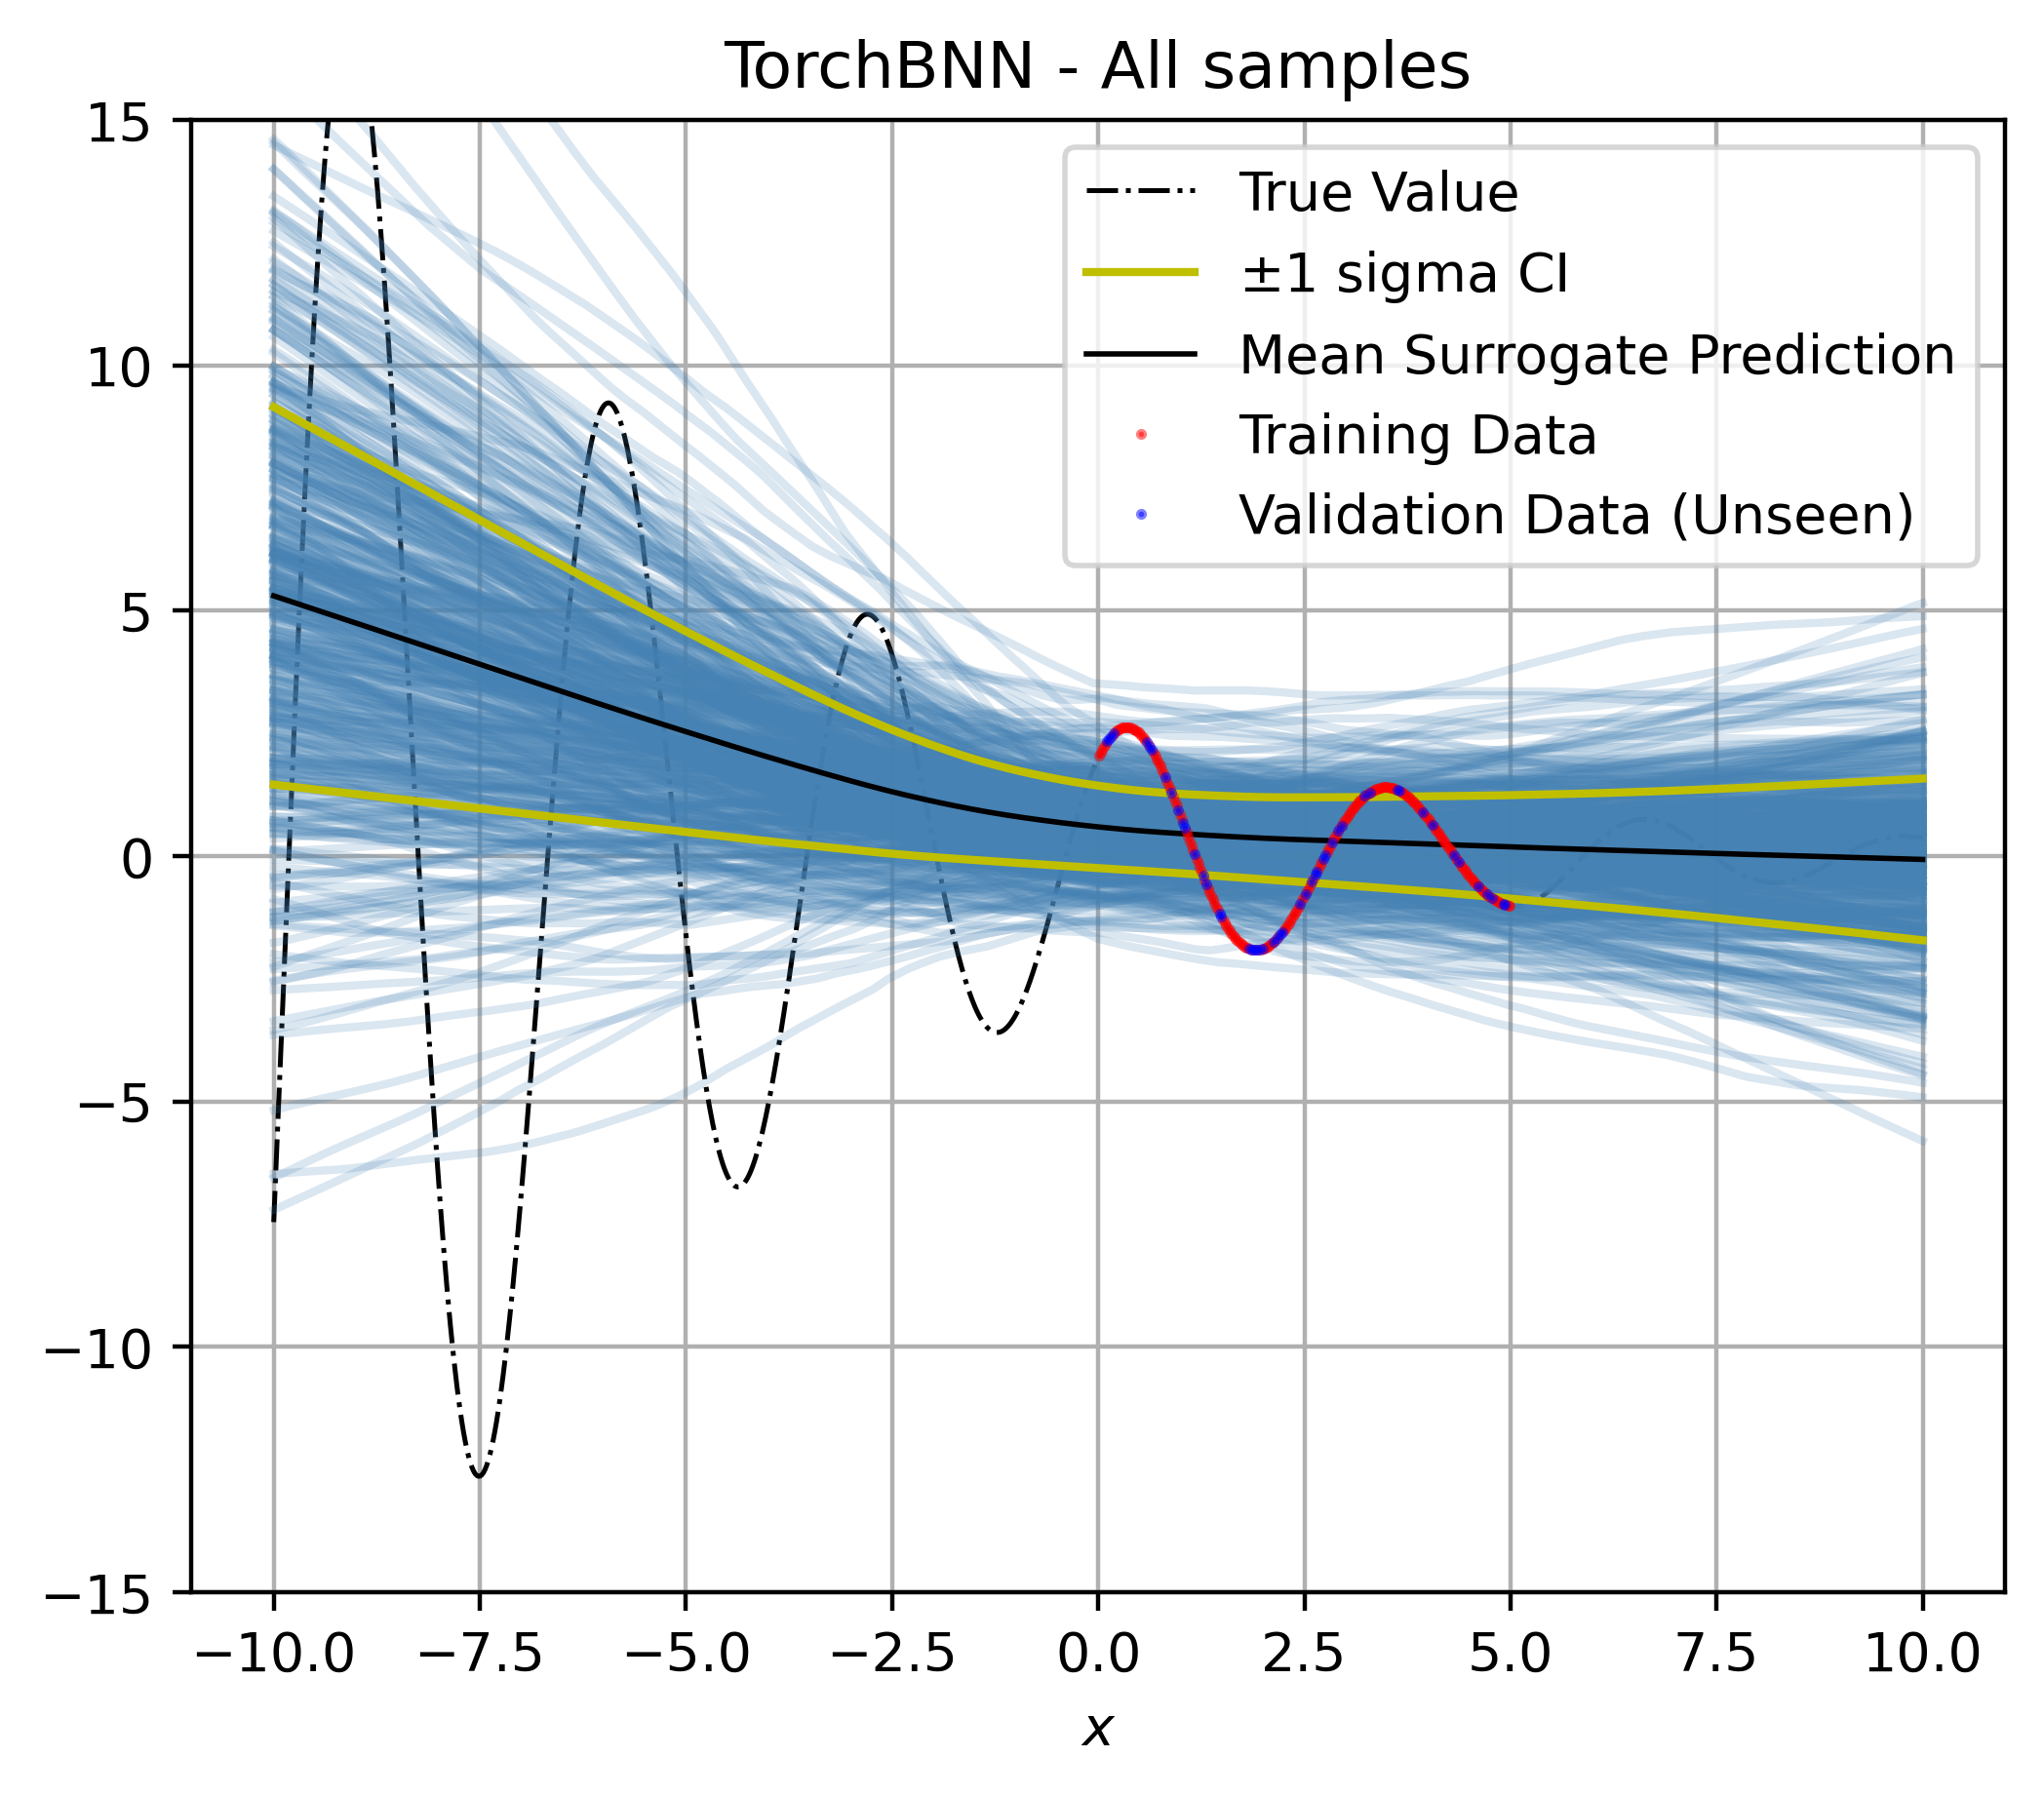

In [19]:
plt.figure(figsize=(6,5), dpi=400)
plt.plot(X, Y, 'k-.',linewidth=0.9,label="True Value")
plt.plot(X, samples_full[:].T,'steelblue',alpha=0.2)
plt.plot(X, means_full_.ravel() + 1*stds_full_.flatten(),'y',label="$\pm$1 sigma CI")
plt.plot(X, means_full_.ravel() - 1*stds_full_.flatten(),'y')
plt.plot(X, means_full_.squeeze(), color = 'black', linewidth = 1, label="Mean Surrogate Prediction")
plt.plot(X[train_indices], Y[train_indices], 'or', alpha = 0.5, markersize=1, label="Training Data")
plt.plot(X[val_indices], Y[val_indices], 'ob', alpha=0.5, markersize=1, label="Validation Data (Unseen)")
plt.ylim((-15,15))
plt.grid()
plt.legend()
plt.xlabel('$x$')
plt.title('TorchBNN - All samples')
plt.show()